In [1]:
import pandas as pd
import os
import gzip
import pickle
import openai
import re
import copy
from tqdm import tqdm
from torch import save,load
import time
import json

In [2]:
df = pd.read_csv('outputs/outputs_chunk_1.csv')

In [3]:
print(df.iloc[3]["output"]) #example: ```json{  "categories": [     "optimistic_speculation","altcoins"

```json
{
  "category": "adoption",
  "sentiment": "neutral"


In [4]:
categories = ["speculation", "adoption", "altcoins", "none"]
sentiments = ["positive", "neutral", "negative", "strongly negative","strongly positive"]


months = {}
months_sentiment = {}

# for i in range(1, 14):
for (i,file) in enumerate(os.listdir('outputs/')):
    i = i+1
    # print(i)
    df = pd.read_csv('outputs/' + file)
    for row in df.iterrows():
        row = row[1]
        index = row["index"]
        date = row["date"] # 2010-01-01 21:46:38
        output = row["output"]
        jsonoutput = output.replace("```json", "")+"}"
        parsed = json.loads(jsonoutput)

        # for each month, get the sum of instances of each category
        month = str(date)[:7]
        if month == "nan":
            print(f"nan found, index: {index} date: {date} output: {output}")
            continue
        if month not in months:
            months[month] = {category: 0 for category in categories}
        for category in categories:
            if category == parsed["category"]:
                months[month][category] += 1

        if month not in months_sentiment:
            months_sentiment[month] = {sentiment: 0 for sentiment in sentiments}
        for sentiment in sentiments:
            if sentiment == parsed["sentiment"]:
                months_sentiment[month][sentiment] += 1




nan found, index: nan date: nan output: ```json
{
  "category": "none",
  "sentiment": "neutral"
nan found, index: nan date: nan output: ```json
{
  "category": "none",
  "sentiment": "neutral"


In [5]:
months

{'2010-01': {'speculation': 0, 'adoption': 10, 'altcoins': 0, 'none': 1},
 '2010-02': {'speculation': 0, 'adoption': 13, 'altcoins': 0, 'none': 0},
 '2010-03': {'speculation': 0, 'adoption': 8, 'altcoins': 0, 'none': 1},
 '2010-04': {'speculation': 0, 'adoption': 9, 'altcoins': 0, 'none': 1},
 '2010-05': {'speculation': 1, 'adoption': 2, 'altcoins': 0, 'none': 0},
 '2010-06': {'speculation': 0, 'adoption': 15, 'altcoins': 0, 'none': 1},
 '2010-07': {'speculation': 2, 'adoption': 80, 'altcoins': 0, 'none': 7},
 '2010-08': {'speculation': 2, 'adoption': 69, 'altcoins': 1, 'none': 15},
 '2011-05': {'speculation': 47, 'adoption': 366, 'altcoins': 1, 'none': 172},
 '2011-06': {'speculation': 296, 'adoption': 829, 'altcoins': 15, 'none': 828},
 '2014-10': {'speculation': 36, 'adoption': 346, 'altcoins': 14, 'none': 120},
 '2014-11': {'speculation': 21, 'adoption': 226, 'altcoins': 1, 'none': 94},
 '2014-12': {'speculation': 22, 'adoption': 275, 'altcoins': 7, 'none': 110},
 '2015-01': {'spec

In [6]:
df = pd.DataFrame(columns=["month"] + categories)
for month in months:
    row = {"month": month}
    for category in categories:
        row[category] = months[month][category]
    df = pd.concat([df, pd.DataFrame([row])])

df = df.sort_values(by="month")
df = df.reset_index(drop=True)

# get the number of posts for each month
posts_count = df[categories].sum(axis=1)

In [7]:
posts_count = posts_count.reset_index(drop=True)

In [8]:
df["posts_count"] = posts_count

In [9]:
df.to_csv('raw_values.csv', index=False)

In [10]:
# Obtain a categorical distribution for each month
for index, row in df.iterrows():
    total = sum(df.loc[index, category] for category in categories)
    # print(total)
    for category in categories:
        df.loc[index, category] = df.loc[index, category] / total


df.to_csv('normalized_values.csv', index=False)

In [11]:
df

,month,speculation,adoption,altcoins,none,posts_count
0,2010-01,0.0,0.909091,0.0,0.090909,11
1,2010-02,0.0,1.0,0.0,0.0,13
2,2010-03,0.0,0.888889,0.0,0.111111,9
3,2010-04,0.0,0.9,0.0,0.1,10
4,2010-05,0.333333,0.666667,0.0,0.0,3
...,...,...,...,...,...,...
166,2023-11,0.192308,0.639423,0.024038,0.144231,208
167,2023-12,0.239819,0.58371,0.022624,0.153846,221
168,2024-01,0.247748,0.603604,0.022523,0.126126,222
169,2024-02,0.211538,0.589744,0.012821,0.185897,156


In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[categories+["posts_count"]] = scaler.fit_transform(df[categories+["posts_count"]])
df.rename(columns={"month":"date"}, inplace=True)
df.to_csv('general.csv', index=False)

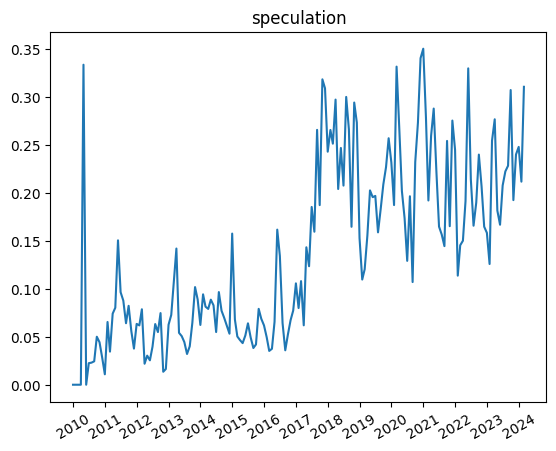

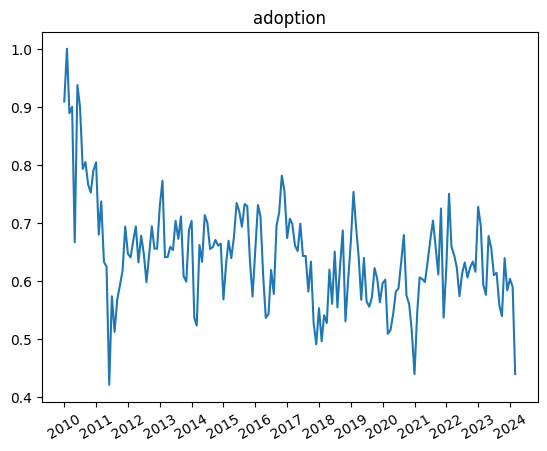

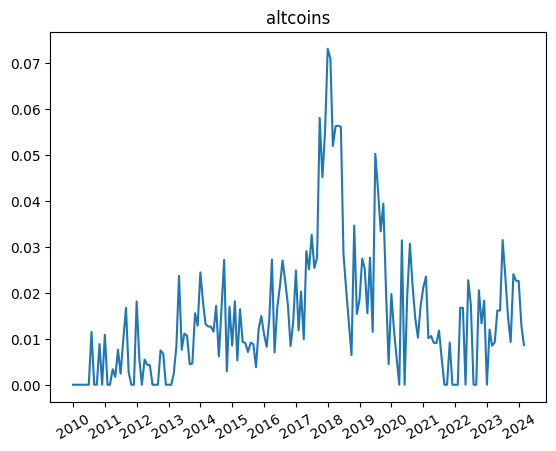

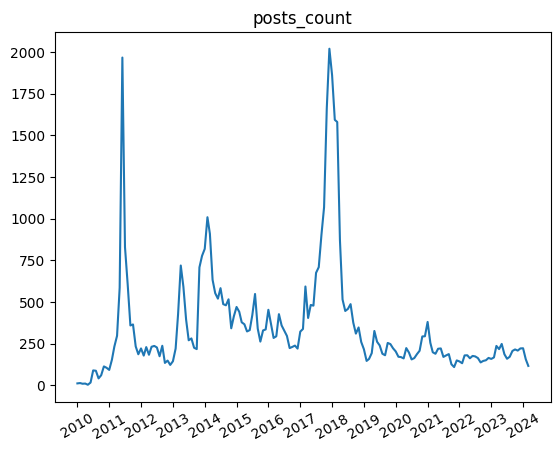

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

df = pd.read_csv('normalized_values.csv')
df["month"] = pd.to_datetime(df["month"])
df = df.set_index("month")

# make a plot for each category

for category in categories[:3]+["posts_count"]:
    fig, ax = plt.subplots()
    ax.plot(df.index, df[category])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_title(category)
    plt.show()

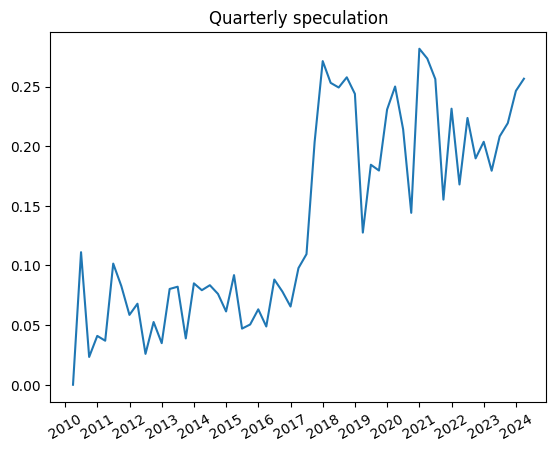

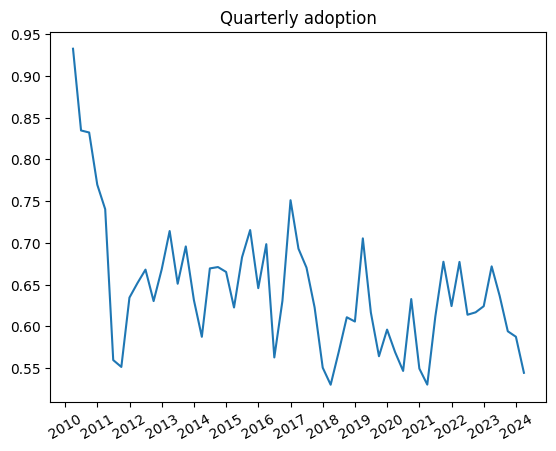

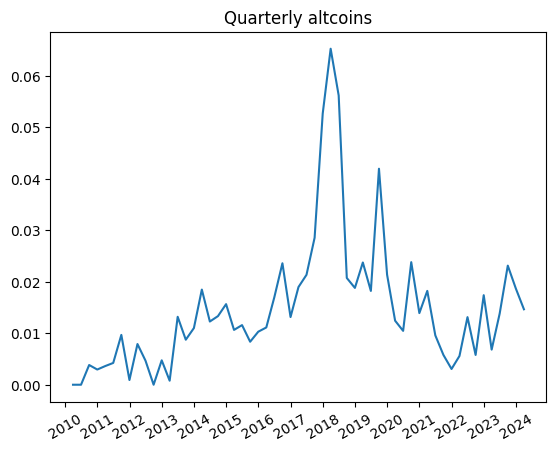

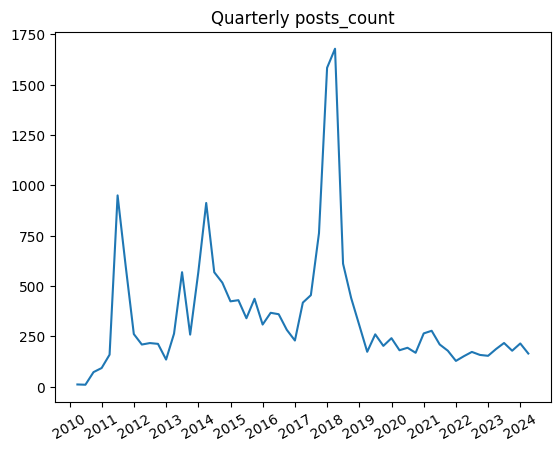

In [14]:
# Aggregate data quarterly for categories
df_quarterly_categories = df.resample('Q').mean()

# Plot quarterly data for each category
for category in categories[:3]+["posts_count"]:
    fig, ax = plt.subplots()
    ax.plot(df_quarterly_categories.index, df_quarterly_categories[category])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_title(f"Quarterly {category}")
    plt.savefig('pdfs/' + category + '.pdf', format='pdf')
    plt.show()

In [15]:
df_sentiments = pd.DataFrame(columns=["month"] + sentiments)
for month in months_sentiment:
    row = {"month": month}
    for sentiment in sentiments:
        row[sentiment] = months_sentiment[month][sentiment]
    df_sentiments = pd.concat([df_sentiments, pd.DataFrame([row])])

df_sentiments = df_sentiments.sort_values(by="month")
df_sentiments = df_sentiments.reset_index(drop=True)

In [16]:
df_sentiments

,month,positive,neutral,negative,strongly negative,strongly positive
0,2010-01,2,9,0,0,0
1,2010-02,1,12,0,0,0
2,2010-03,3,6,0,0,0
3,2010-04,2,8,0,0,0
4,2010-05,1,2,0,0,0
...,...,...,...,...,...,...
166,2023-11,73,101,34,0,0
167,2023-12,82,96,43,0,0
168,2024-01,81,113,28,0,0
169,2024-02,47,86,23,0,0


In [17]:
# Obtain a categorical distribution for each month
for index, row in df_sentiments.iterrows():
    total = sum(df_sentiments.loc[index, sentiment] for sentiment in sentiments)
    # print(total)
    for sentiment in sentiments:
        df_sentiments.loc[index, sentiment] = df_sentiments.loc[index, sentiment] / total


df_sentiments

,month,positive,neutral,negative,strongly negative,strongly positive
0,2010-01,0.181818,0.818182,0.0,0.0,0.0
1,2010-02,0.076923,0.923077,0.0,0.0,0.0
2,2010-03,0.333333,0.666667,0.0,0.0,0.0
3,2010-04,0.2,0.8,0.0,0.0,0.0
4,2010-05,0.333333,0.666667,0.0,0.0,0.0
...,...,...,...,...,...,...
166,2023-11,0.350962,0.485577,0.163462,0.0,0.0
167,2023-12,0.371041,0.434389,0.19457,0.0,0.0
168,2024-01,0.364865,0.509009,0.126126,0.0,0.0
169,2024-02,0.301282,0.551282,0.147436,0.0,0.0


In [18]:
df_sentiments.to_csv('normalized_values_sentiment.csv', index=False)

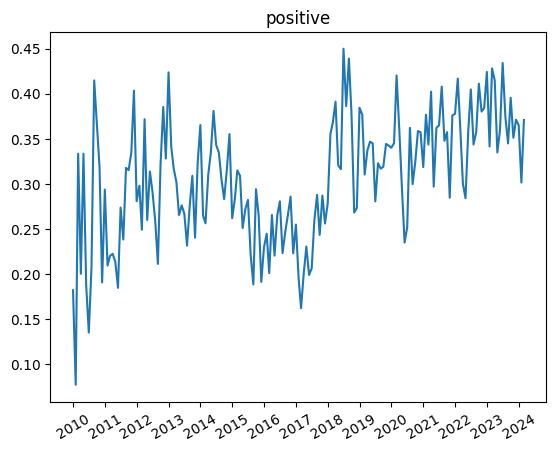

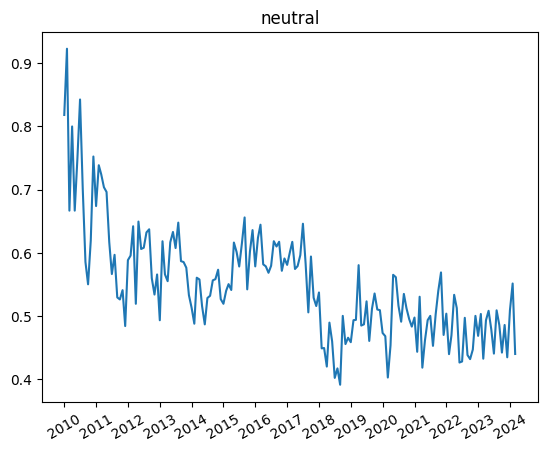

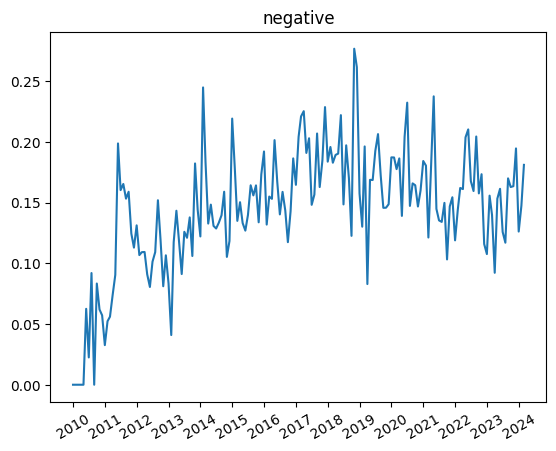

In [19]:
df_sentiments = pd.read_csv('normalized_values_sentiment.csv')
df_sentiments["month"] = pd.to_datetime(df_sentiments["month"])
df_sentiments = df_sentiments.set_index("month")

# make a plot for each category

for sentiment in sentiments[:3]:
    fig, ax = plt.subplots()
    ax.plot(df_sentiments.index, df_sentiments[sentiment])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_title(sentiment)
    plt.show()

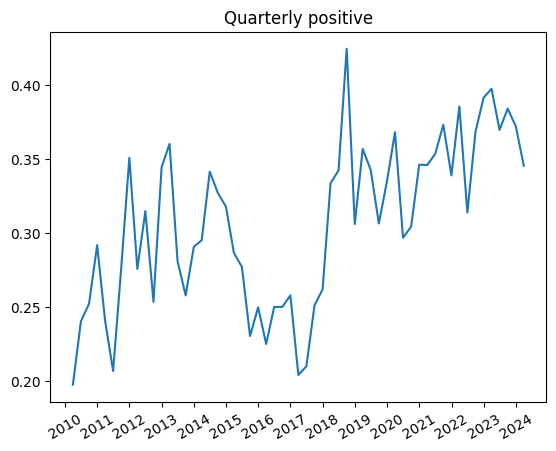

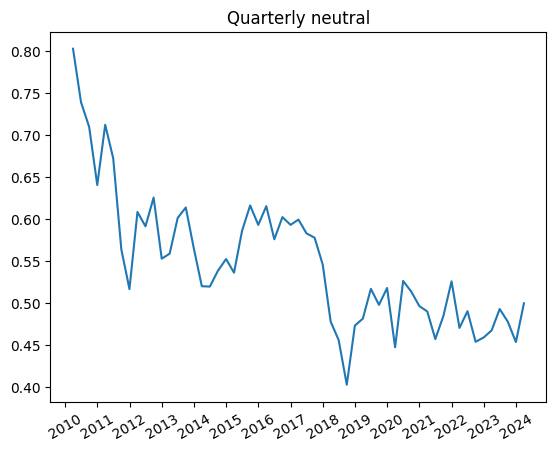

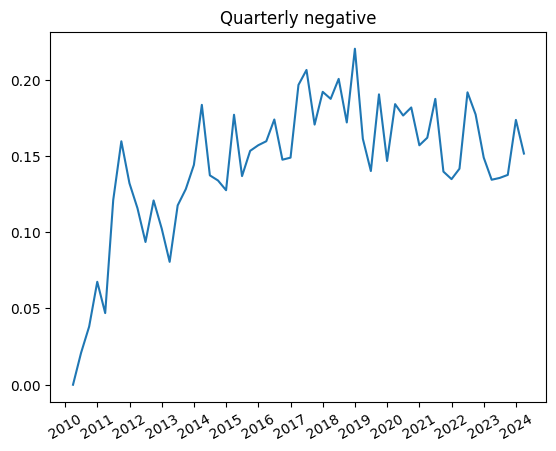

: 

In [20]:
# Aggregate data quarterly for sentiments
df_quarterly_sentiments = df_sentiments.resample('Q').mean()

# Plot quarterly data for each sentiment
for sentiment in sentiments[:3]:
    fig, ax = plt.subplots()
    ax.plot(df_quarterly_sentiments.index, df_quarterly_sentiments[sentiment])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # ax.xaxis.set_minor_locator(mdates.MonthLocator())
    # ax.xaxis.set_minor_formatter(mdates.DateFormatter('%m'))
    ax.xaxis.set_tick_params(rotation=30)
    ax.set_title(f"Quarterly {sentiment}")
    plt.savefig('pdfs/' + sentiment + '.pdf', format='pdf')
    plt.show()